In [25]:
import gym
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def policy(state, Q1, Q2):
    epsilon = 0.2
    if np.random.rand() < epsilon:
        return np.random.choice([0, 1, 2])  # 0: Stick, 1: Hit, 2: Double Down
    else:
        q_values = np.array([Q1[state][a] + Q2[state][a] for a in range(3)])
        return np.argmax(q_values)

def double_q_update(state, action, reward, next_state, done, Q1, Q2, alpha, gamma):
    if done:
        next_state_value = 0
    else:
        next_state_value = np.max(Q1[next_state] + Q2[next_state])
    
    if np.random.rand() < 0.5:
        Q1[state][action] += alpha * (reward + gamma * next_state_value - Q1[state][action])
    else:
        Q2[state][action] += alpha * (reward + gamma * next_state_value - Q2[state][action])

def handle_double_down(env, state, Q1, Q2, alpha, gamma):
    next_state, reward, done, _, _ = env.step(1)  # Take one hit
    if not done: 
        next_state, reward, done, _, _ = env.step(0)  # Then stand
    reward *= 2  # Double the reward
    return next_state, reward, done

def update_q_values(env, Q1, Q2, alpha, gamma):
    state = env.reset()
    state = state[0]
    done = False
    while not done:
        action = policy(state, Q1, Q2)
        if action == 2:  # Double down action
            next_state, reward, done = handle_double_down(env, state, Q1, Q2, alpha, gamma)
        else:
            next_state, reward, done, _, _ = env.step(action)
        double_q_update(state, action, reward, next_state, done, Q1, Q2, alpha, gamma)
        state = next_state

In [26]:
def prepare_data_for_heatmap(Q1, Q2):
    data = {
        'Player Sum': [],
        'Dealer Card': [],
        'Has Usable Ace': [],
        'Value': []
    }
    for key in Q1.keys():
        player_sum, dealer_card, usable_ace = key
        summed_values = np.array(Q1[key]) + np.array(Q2[key])
        best_action_value = max(summed_values)
        data['Player Sum'].append(player_sum)
        data['Dealer Card'].append(dealer_card)
        data['Has Usable Ace'].append('Yes' if usable_ace else 'No')
        data['Value'].append(best_action_value)
    return pd.DataFrame(data)

def plot_heatmap(df, title="Value Function"):
    if 'Has Usable Ace' in df.columns:
        df_yes = df[(df['Has Usable Ace'] == 'Yes') & (df['Player Sum'] >= 12)]
        df_no = df[(df['Has Usable Ace'] == 'No') & (df['Player Sum'] >= 4)]
        
        if not df_yes.empty:
            pivot_table_yes = df_yes.pivot(index="Player Sum", columns="Dealer Card", values="Value")
            plt.figure(figsize=(12, 9))
            sns.heatmap(pivot_table_yes, cmap="coolwarm", annot=True, fmt=".2f")
            plt.title(f"{title} (Usable Ace = Yes)")
            plt.ylabel("Player's Sum")
            plt.xlabel("Dealer's Showing Card")
            plt.show()

        if not df_no.empty:
            pivot_table_no = df_no.pivot(index="Player Sum", columns="Dealer Card", values="Value")
            plt.figure(figsize=(12, 9))
            sns.heatmap(pivot_table_no, cmap="coolwarm", annot=True, fmt=".2f")
            plt.title(f"{title} (Usable Ace = No)")
            plt.ylabel("Player's Sum")
            plt.xlabel("Dealer's Showing Card")
            plt.show()

def prepare_data_for_heatmap_action(Q1, Q2):
    data = {
        'Player Sum': [],
        'Dealer Card': [],
        'Has Usable Ace': [],
        'Value': []
    }
    for key in Q1.keys():
        player_sum, dealer_card, usable_ace = key
        summed_values = np.array(Q1[key]) + np.array(Q2[key])
        which_action_state = np.argmax(summed_values)
        data['Player Sum'].append(player_sum)
        data['Dealer Card'].append(dealer_card)
        data['Has Usable Ace'].append('Yes' if usable_ace else 'No')
        data['Value'].append(which_action_state)
    return pd.DataFrame(data)

def plot_heatmap_action(df, title="Optimal Action Plot"):
    if 'Has Usable Ace' in df.columns:
        df_yes = df[(df['Has Usable Ace'] == 'Yes') & (df['Player Sum'] >= 12)]
        df_no = df[(df['Has Usable Ace'] == 'No') & (df['Player Sum'] >= 4)]
        
        if not df_yes.empty:
            df_yes['Action'] = df_yes['Value'].replace({0: 'S', 1: 'H', 2: 'DD'})
            pivot_table_actions_yes = df_yes.pivot(index="Player Sum", columns="Dealer Card", values="Action")
            action_mapping = {'H': 0, 'S': 1, 'DD': 2}
            colormap_values_yes = pivot_table_actions_yes.replace(action_mapping)
            plt.figure(figsize=(12, 9))
            sns.heatmap(colormap_values_yes, cmap="coolwarm", annot=pivot_table_actions_yes, fmt="", cbar=False)
            plt.title(f"{title} (Usable Ace = Yes)")
            plt.ylabel("Player's Sum")
            plt.xlabel("Dealer's Showing Card")
            plt.show()

        if not df_no.empty:
            df_no['Action'] = df_no['Value'].replace({0: 'S', 1: 'H', 2: 'DD'})
            pivot_table_actions_no = df_no.pivot(index="Player Sum", columns="Dealer Card", values="Action")
            action_mapping = {'H': 0, 'S': 1, 'DD': 2}
            colormap_values_no = pivot_table_actions_no.replace(action_mapping)
            plt.figure(figsize=(12, 9))
            sns.heatmap(colormap_values_no, cmap="coolwarm", annot=pivot_table_actions_no, fmt="", cbar=False)
            plt.title(f"{title} (Usable Ace = No)")
            plt.ylabel("Player's Sum")
            plt.xlabel("Dealer's Showing Card")
            plt.show()



In [21]:
env = gym.make('Blackjack-v1')
gamma = 0.8 
alpha = 0.1  
num_episodes = 20000000

Q1 = {(player, dealer, ace): [0, 0, 0] for player in range(4, 22) for dealer in range(1, 11) for ace in [False, True]}
Q2 = {(player, dealer, ace): [0, 0, 0] for player in range(4, 22) for dealer in range(1, 11) for ace in [False, True]}

for i in range(num_episodes):
    update_q_values(env, Q1, Q2, alpha, gamma)
    if (i%100000==0):
        print("episode no: ", i)

for state in list(Q1.keys())[-10:-1]:
    print(f"State: {state}, Q1: {Q1[state]}, Q2: {Q2[state]}")
    print("\n")

/home/dipit/anaconda3/envs/ds/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode no:  0
episode no:  100000
episode no:  200000
episode no:  300000
episode no:  400000
episode no:  500000
episode no:  600000
episode no:  700000
episode no:  800000
episode no:  900000
episode no:  1000000
episode no:  1100000
episode no:  1200000
episode no:  1300000
episode no:  1400000
episode no:  1500000
episode no:  1600000
episode no:  1700000
episode no:  1800000
episode no:  1900000
episode no:  2000000
episode no:  2100000
episode no:  2200000
episode no:  2300000
episode no:  2400000
episode no:  2500000
episode no:  2600000
episode no:  2700000
episode no:  2800000
episode no:  2900000
episode no:  3000000
episode no:  3100000
episode no:  3200000
episode no:  3300000
episode no:  3400000
episode no:  3500000
episode no:  3600000
episode no:  3700000
episode no:  3800000
episode no:  3900000
episode no:  4000000
episode no:  4100000
episode no:  4200000
episode no:  4300000
episode no:  4400000
episode no:  4500000
episode no:  4600000
episode no:  4700000
episode

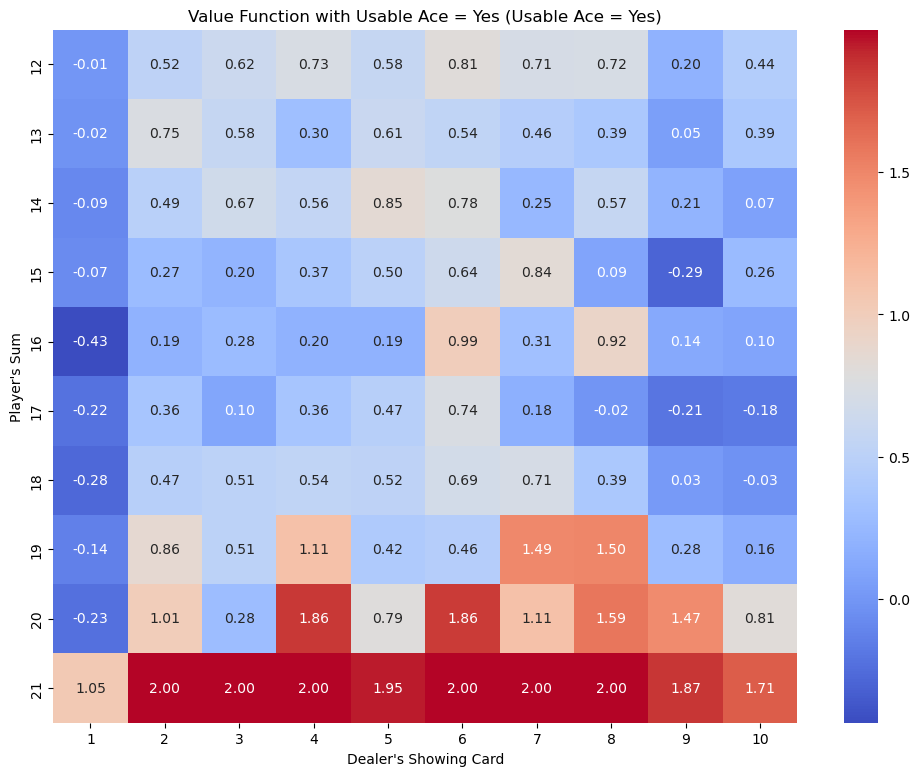

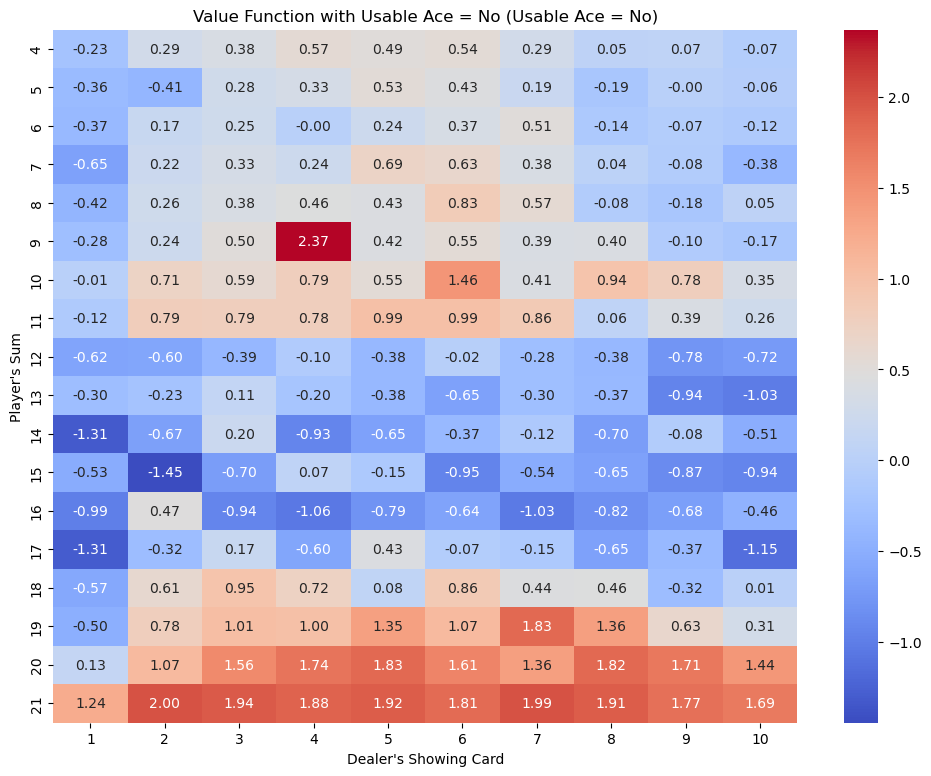

In [22]:
df = prepare_data_for_heatmap(Q1,Q2)

for has_ace in ['Yes', 'No']:
    filtered_df = df[df['Has Usable Ace'] == has_ace]
    plot_heatmap(filtered_df, f"Value Function with Usable Ace = {has_ace}")

/tmp/ipykernel_5101/1180413134.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yes['Action'] = df_yes['Value'].replace({0: 'S', 1: 'H', 2: 'DD'})


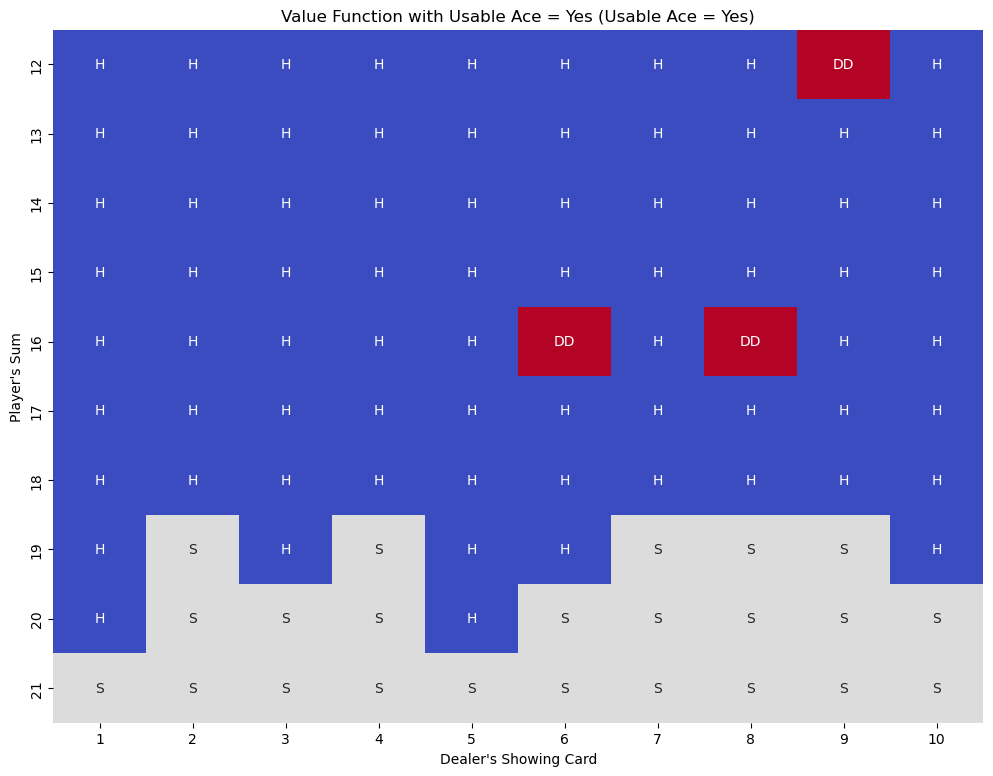

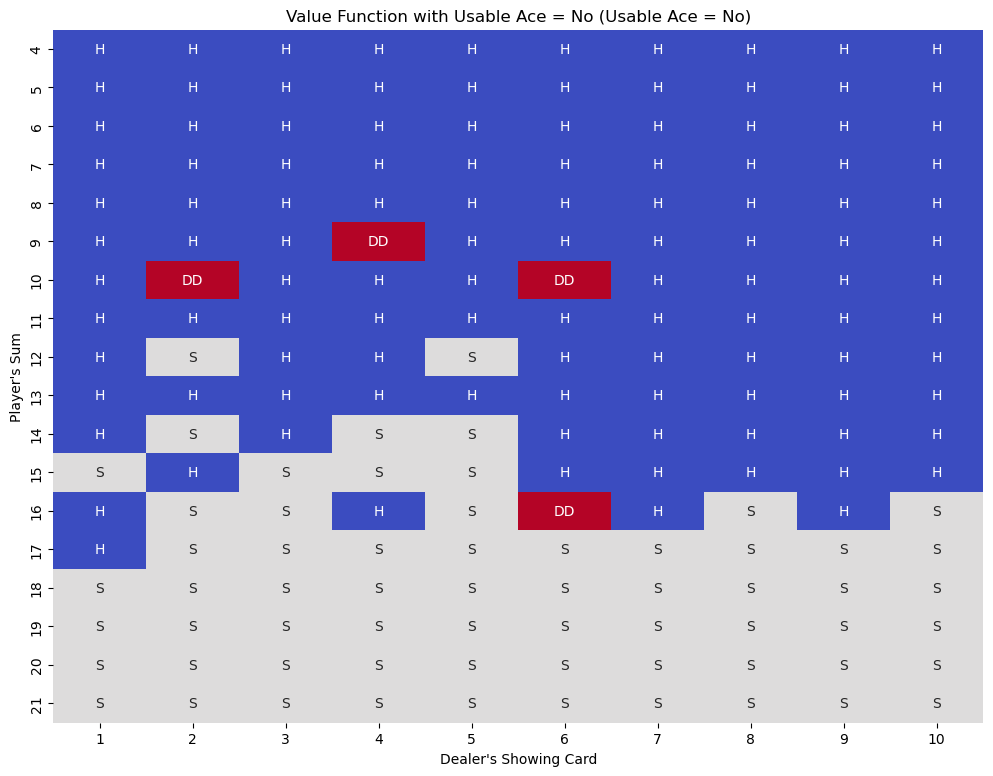

In [23]:

df = prepare_data_for_heatmap_action(Q1,Q2)

for has_ace in ['Yes', 'No']:
    filtered_df = df[df['Has Usable Ace'] == has_ace]
    plot_heatmap_action(filtered_df, f"Value Function with Usable Ace = {has_ace}")


In [24]:
df.to_csv('final.csv', sep=',', index=False, encoding='utf-8')
